In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/EEG_GAN/Models/eeg-to-fmri/src/

/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src


In [ ]:
!pip install --upgrade eeg-to-fmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 125.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.1 MB/s eta 0:00:0

In [ ]:
from torch.utils.data import Dataset
import math
import numpy as np
import nibabel.processing
from nilearn import image, masking
import nibabel as nib
import mne
import json
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy import ndimage

def fmri_norm(volume, scaler=StandardScaler()):
  # flatten = volume.flatten().reshape((-1, 1))
  # normed = scaler.fit_transform(flatten).reshape(volume.shape)
  mini = np.min(volume, axis=(0, 1), keepdims=True)
  maxi = np.max(volume, axis=(0, 1), keepdims=True)
  normed = (volume - mini) / (maxi - mini)
  assert normed.max() <= 1 and normed.min() >= 0
  return normed

scaler = StandardScaler()

def get_eeg_subjects(dir="/content/drive/MyDrive/EEG_GAN/datasets/datasets/ds002338"):
    # eeg files are inside 'derivatives'
    eeg_root = os.path.join(dir, 'derivatives')
    fmri_root = dir
    eeg_subjects = [f for f in os.listdir(eeg_root) if 'sub' in f]
    # print(eeg_subjects)
    _1dNF_paths = []
    _2dNF_paths = []
    _pre_paths = []
    _post_paths = []
    eeg_fmri_table = {}
    for sub in eeg_subjects:
      path = os.path.join(eeg_root, sub, 'eeg_pp')
      experiment_files = [f for f in os.listdir(path) if 'vhdr' in f]
      # print(experiment_files)

      fmri_path = os.path.join(fmri_root, sub, 'func')

      for exp in experiment_files:
        eeg_p = os.path.join(path, exp)
        if '1dNF' in exp:
          _1dNF_paths.append(eeg_p)
          if 'run-01' in exp:
            fmri_p = os.path.join(fmri_path, f'{sub}_task-1dNF_run-01_bold.nii.gz')
          elif 'run-02' in exp:
            fmri_p = os.path.join(fmri_path, f'{sub}_task-1dNF_run-02_bold.nii.gz')
          else:
            fmri_p = os.path.join(fmri_path, f'{sub}_task-1dNF_run-03_bold.nii.gz')
        elif '2dNF' in exp:
          _2dNF_paths.append(eeg_p)
          if 'run-01' in exp:
            fmri_p = os.path.join(fmri_path, f'{sub}_task-2dNF_run-01_bold.nii.gz')
          elif 'run-02' in exp:
            fmri_p = os.path.join(fmri_path, f'{sub}_task-2dNF_run-02_bold.nii.gz')
          else:
            fmri_p = os.path.join(fmri_path, f'{sub}_task-2dNF_run-03_bold.nii.gz')
        else: # control
          if 'post' in exp:
            _post_paths.append(eeg_p)
            fmri_p = os.path.join(fmri_path, f'{sub}_task-MIpost_bold.nii.gz')
          else:
            _pre_paths.append(eeg_p)
            fmri_p = os.path.join(fmri_path, f'{sub}_task-MIpre_bold.nii.gz')

        eeg_fmri_table[eeg_p] = fmri_p

    return _1dNF_paths, _2dNF_paths, _pre_paths, _post_paths, eeg_fmri_table

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 32
    desired_width = 64
    desired_height = 64
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    # img = ndimage.rotate(img, 90, reshape=False)

    img = ndimage.zoom(img, (depth_factor, height_factor, width_factor), order=1)
    return img

def parse_one_file(eeg_signal, fmri, start_time, end_time, pre_post, window=5, sampling_rate=200, lag=0, ifresize=True):
    result_eeg = []
    result_fmri = []
    # if ifresize:
      # img = np.swapaxes(np.swapaxes(np.swapaxes(fmri.get_fdata(), 0, 3), 1,2), 1,3)
      # dct = DCT3D(*img.shape[1:])
      # downsample_shape = (64, 64, 32)
      # idct = padded_iDCT3D(*(downsample_shape[:2]+(img.shape[3],)+downsample_shape))
      # resampled = image.new_img_like(fmri, np.swapaxes(np.swapaxes(np.swapaxes(idct(dct(img).numpy()[:, :downsample_shape[0], :downsample_shape[1], :]).numpy(), 0, 3), 0,2), 0,1))
      # print("Finished resampling... shape is ", resampled.get_fdata().shape)
      # fmri = resampled.get_fdata()

    fmri = fmri.get_fdata()

    step = window*sampling_rate
    scaler = StandardScaler()
    if pre_post:
      step = sampling_rate*2 # shorter step due to insufficient data

    for t in range(start_time, end_time, step):
        s = np.array(eeg_signal[:, t:t+sampling_rate]) # take 1 second of eeg data, considering the potential size of model
        assert s.shape == (64, 200)
        # eeg normalization??
        # mini = np.min(s, axis=1, keepdims=True)
        # maxi = np.max(s, axis=1, keepdims=True)
        # normed = (s - mini) / (maxi - mini)
        result_eeg.append(s)

        # fmri slice normalization + resample
        fmri_slice_start = math.ceil(start_time/sampling_rate)
        sub_volume = np.array(fmri[:, :, :, lag+fmri_slice_start]) # 104, 106, 16
        h, w, d = sub_volume.shape
        sub_volume = np.swapaxes(np.swapaxes(sub_volume, 0, 2), 1, 2)

        normed = resize_volume(fmri_norm(sub_volume, scaler))
        assert normed.shape == (32, 64, 64)
        # print(normed.shape)
        result_fmri.append(normed)
    # print("Finished parsing")
    # print(np.array(result_eeg).shape)
    # print(np.array(result_fmri).shape)
    print("Finished parsing one file")
    return result_eeg, result_fmri

def extract_eeg_fmri_pairs_one_file(raw_eeg, raw_fmri, target_code=2, rest_code=99, pre_post=False, ratio = 0.9):
    events, annotations = mne.events_from_annotations(raw_eeg)
    signal = raw_eeg.get_data()
    all_eeg = []
    all_fmri = []
    start = None
    end = None
    find_start = False
    start_end_times = []
    for time, _, event_code in events:
        if event_code == target_code:
            # this is a task trial
            start = time
            find_start = True
        elif event_code == rest_code and find_start:
            # print("Find the end of a stimulus event: ")
            # print(f"Start: {start}; End: {time}")
            start_end_times.append(str([start, time]))
            eeg_fragments, fmri_fragments = parse_one_file(signal, raw_fmri, start, time, pre_post=pre_post)
            all_eeg.extend(eeg_fragments)
            all_fmri.extend(fmri_fragments)
            find_start = False

    p = np.random.permutation(len(all_eeg))
    all_eeg = np.array(all_eeg)[p]
    all_fmri = np.array(all_fmri)[p]
    # eeg_mu = all_eeg.mean()
    # eeg_sig = all_eeg.std()
    mini = np.min(all_eeg)
    maxi = np.max(all_eeg)
    all_eeg = (all_eeg - mini) / (maxi - mini)

    # eeg  z-score normalize
    train_eeg = np.array(all_eeg[:int(all_eeg.shape[0]*ratio)])
    test_eeg = np.array(all_eeg[int(all_eeg.shape[0]*ratio):])
    train_fmri = np.array(all_fmri[:int(all_fmri.shape[0]*ratio)])
    test_fmri = np.array(all_fmri[int(all_fmri.shape[0]*ratio):])
    return train_eeg, train_fmri, test_eeg, test_fmri, start_end_times


def segment_data(dataset_table):
    all_subject_eeg_train = []
    all_subject_eeg_test = []
    all_subject_fmri_train = []
    all_subject_fmri_test = []
    all_subject_label_train = []
    all_subject_label_test = []
    inf = {}
    for eeg_file in dataset_table.keys():
      print(f"=====>>>> Segmenting {eeg_file}")
      eeg = mne.io.read_raw_brainvision(eeg_file)
      events, annotations = mne.events_from_annotations(eeg)
      # print(events[:10])
      try:
        fmri_img = image.load_img(dataset_table[eeg_file])
      except:
        print(f"Failed to load {dataset_table[eeg_file]}... Skipping it")
        continue
      if '1dNF' in eeg_file:
        label = 0
      elif '2dNF' in eeg_file:
        label = 1
      elif 'pre' in eeg_file:
        label = 2
      else:
        label = 3
      eeg_seg_train, fmri_seg_train, eeg_seg_test, fmri_seg_test, times = extract_eeg_fmri_pairs_one_file(eeg, fmri_img) # one subject
      inf[eeg_file] = times
      all_subject_eeg_train.extend(eeg_seg_train)
      all_subject_eeg_test.extend(eeg_seg_test)

      all_subject_fmri_train.extend(fmri_seg_train)
      all_subject_fmri_test.extend(fmri_seg_test)
      all_subject_label_train.extend([label]*len(eeg_seg_train))
      all_subject_label_test.extend([label]*len(eeg_seg_test))

    # permute
    p = np.random.permutation(len(all_subject_eeg_train))
    all_subject_eeg_train = np.stack(all_subject_eeg_train, axis=0)[p]
    all_subject_fmri_train = np.stack(all_subject_fmri_train, axis=0)[p]
    all_subject_label_train = np.array(all_subject_label_train)[p]

    p = np.random.permutation(len(all_subject_eeg_test))
    all_subject_eeg_test = np.stack(all_subject_eeg_test, axis=0)[p]
    all_subject_fmri_test = np.stack(all_subject_fmri_test, axis=0)[p]
    all_subject_label_test = np.array(all_subject_label_test)[p]
    with open('times.json', 'w') as fr:
      json.dump(inf, fr, indent=4)

    return np.expand_dims(all_subject_eeg_train, axis=1), np.expand_dims(all_subject_eeg_test, axis=1), np.expand_dims(all_subject_fmri_train, axis=1), np.expand_dims(all_subject_fmri_test, axis=1), all_subject_label_train, all_subject_label_test



In [ ]:
# _1dNF, _2dNF, pre, post, dataset_table = get_eeg_subjects(dir="/content/drive/MyDrive/EEG_GAN/datasets/datasets/ds002338")

# # train test splitted
# train_e, test_e, train_f, test_f, train_l, test_l = segment_data(dataset_table)

In [ ]:
# # train and test data
# fmri_train_new = train_f
# fmri_test_new = test_f
# # label
# fmri_train_label = train_l
# fmri_test_label = test_l
# # transpose
# fmri_train_new = fmri_train_new.transpose(0,4,3,2,1)
# fmri_test_new = fmri_test_new.transpose(0,4,3,2,1)
# # train_f[100][0][3][2][1] - fmri_train_new[100][1][2][3][0]

In [ ]:
import tensorflow as tf
import numpy as np
import sys

import os


#define the environment variables
os.environ['EEG_FMRI_DATASETS']="/content/drive/MyDrive/EEG_GAN/datasets/datasets"
os.environ['EEG_FMRI']="/content/drive/MyDrive/EEG_GAN/datasets"

import eeg_to_fmri
from eeg_to_fmri.utils import tf_config

dataset="05"
tf_config.set_seed(seed=2)
# tf_config.setup_tensorflow(device="GPU", run_eagerly=True)

from eeg_to_fmri.models.synthesizers import EEG_to_fMRI
from eeg_to_fmri.data import preprocess_data, eeg_utils, data_utils
from eeg_to_fmri.learning import train, losses
from eeg_to_fmri import metrics
from eeg_to_fmri.utils import viz_utils

In [ ]:
%cd eeg_to_fmri
!export EEG_FMRI_DATASETS="/content/drive/MyDrive/EEG_GAN/datasets/datasets"
!export EEG_FMRI="/content/drive/MyDrive/EEG_GAN/datasets/"

/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri


In [ ]:
device_name = tf.config.list_physical_devices()
device_name

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print(os.environ['EEG_FMRI'])

/content/drive/MyDrive/EEG_GAN/datasets


In [ ]:
n_individuals=getattr(data_utils, "n_individuals_"+dataset)
interval_eeg=10
print(n_individuals)
with tf.device('GPU:0'):

    task = "1dNF_run"
    train_data, test_data = preprocess_data.dataset(dataset, task=task, n_individuals=n_individuals, interval_eeg=interval_eeg, ind_volume_fit=False, standardize_fmri=True, iqr=False, verbose=True)
    eeg_train, fmri_train = train_data
    # eeg_test, fmri_test = test_data
    fmri_random_index = np.random.choice(fmri_train.shape[0], size=1000, replace=False)
    fmri_random = fmri_train[fmri_random_index]
    fmri_train_data = fmri_random


    task = "2dNF_run"
    train_data, test_data = preprocess_data.dataset(dataset, task=task, n_individuals=n_individuals, interval_eeg=interval_eeg, ind_volume_fit=False, standardize_fmri=True, iqr=False, verbose=True)
    eeg_train, fmri_train = train_data
    # eeg_test, fmri_test2 = test_data
    fmri_random_index = np.random.choice(fmri_train.shape[0], size=1000, replace=False)
    fmri_random = fmri_train[fmri_random_index]
    fmri_train_data = np.concatenate((fmri_train_data,fmri_random),axis=0)

    task = "MIpre"
    train_data, test_data = preprocess_data.dataset(dataset, task=task, n_individuals=n_individuals, interval_eeg=interval_eeg, ind_volume_fit=False, standardize_fmri=True, iqr=False, verbose=True)
    eeg_train, fmri_train = train_data
    # eeg_test, fmri_test3 = test_data
    fmri_random_index = np.random.choice(fmri_train.shape[0], size=1000, replace=False)
    fmri_random = fmri_train[fmri_random_index]
    fmri_train_data = np.concatenate((fmri_train_data,fmri_random),axis=0)


    task = "MIpost"
    train_data, test_data = preprocess_data.dataset(dataset, task=task, n_individuals=n_individuals, interval_eeg=interval_eeg, ind_volume_fit=False, standardize_fmri=True, iqr=False, verbose=True)
    eeg_train, fmri_train = train_data
    # eeg_test, fmri_test4 = test_data
    fmri_random_index = np.random.choice(fmri_train.shape[0], size=1000, replace=False)
    fmri_random = fmri_train[fmri_random_index]
    fmri_train_data = np.concatenate((fmri_train_data,fmri_random),axis=0)



17
I: Starting to Load Data
dataset is  05
sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


I: Finished Loading Data
?????
3822
3822
I: Pairs Created
I: Starting to Load Data
dataset is  05
sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


I: Finished Loading Data
?????
3822
3822
I: Pairs Created
I: Starting to Load Data
dataset is  05
sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


I: Finished Loading Data
?????
3822
3822
I: Pairs Created
I: Starting to Load Data
dataset is  05
sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


sub-xp201
sub-xp202
sub-xp203
sub-xp204
sub-xp205
sub-xp206
sub-xp207
sub-xp210
sub-xp211
sub-xp213
sub-xp216
sub-xp217
sub-xp218
sub-xp219
sub-xp220
sub-xp221
sub-xp222


/content/drive/.shortcut-targets-by-id/1z_ln8fPatUI4267ZmBksH4kCb2zS8RqM/EEG_GAN/Models/eeg-to-fmri/src/eeg_to_fmri/data/eeg_utils.py:212: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)


I: Finished Loading Data
?????
3822
3822
I: Pairs Created


In [ ]:
labels_train = np.repeat(np.arange(4), 1000)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import os
import random
import numpy as np
import nibabel as nib
from scipy import ndimage
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt


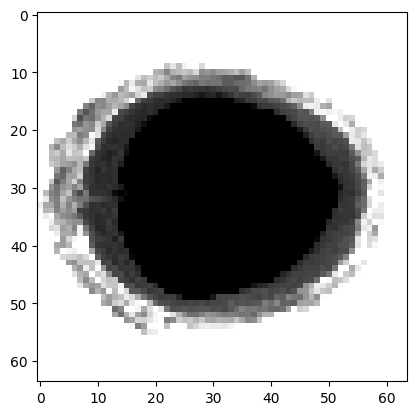

In [ ]:
import numpy as np

def minmax_normalize_matrix(matrix):
    min_vals = np.min(matrix, axis=0)
    max_vals = np.max(matrix, axis=0)
    normalized_matrix = (matrix - min_vals) / (max_vals - min_vals)
    return normalized_matrix

normalized_fmri_train = minmax_normalize_matrix(fmri_train_data)
import matplotlib.pyplot as plt
plt.imshow(normalized_fmri_train[107][:,:,13,0],cmap='gray')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import os
import random
import numpy as np
import nibabel as nib
from scipy import ndimage
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

print ("nums GPU",len(tf.config.list_physical_devices('GPU')))

nums GPU 1


In [ ]:
SEED=123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC']='1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        zMean,zLogVar=inputs
        batch=tf.shape(zMean)[0]
        dim=tf.shape(zMean)[1]
        epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
        return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [ ]:
def buildEncoder(latentDim, num_labels):
    encoderInputs = layers.Input(shape=(64, 64, 32, 1))
    labelInputs = layers.Input(shape=(num_labels,))

    l1 = keras.models.Sequential([
        layers.Conv3D(128, 3, activation="relu", strides=2, padding="same"),
        layers.Conv3D(64, 3, activation="relu", strides=2, padding="same"),
        layers.Flatten(),
        # layers.Dense(256, activation="relu")
    ])

    x = l1(encoderInputs)
    combinedInputs = layers.concatenate([x, labelInputs], axis=1)

    x = layers.Dense(256, activation="relu")(combinedInputs)
    zMean = layers.Dense(latentDim, name="z_mean")(x)

    zLogVar = layers.Dense(latentDim,name="z_log_var")(x)

    z =  SamplingLayer()([zMean, zLogVar])

    return keras.Model([encoderInputs, labelInputs], [zMean, zLogVar, z], name="encoder")

# encoderInputs = keras.Input(shape=(64, 64, 32, 1))
# encoder = buildEncoder(3,encoderInputs)
# encoder.summary()

In [ ]:
def buildDecoder(latentDim, num_labels):

    latentInputs = layers.Input(shape=(latentDim,))
    labelInputs = layers.Input(shape=(num_labels,))
    combinedInputs = layers.concatenate([latentInputs, labelInputs],axis=1)
    l1 = keras.models.Sequential([
        layers.Dense(16*16*8*32, activation="relu", input_shape=(combinedInputs.shape[1],)),
        layers.Reshape((16,16,8,32)),
        layers.Conv3DTranspose(filters=128, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv3DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding="same"),
        layers.Conv3DTranspose(filters=1, kernel_size=3, activation="sigmoid", padding="same")
    ])

    return keras.Model([latentInputs, labelInputs], l1(combinedInputs), name="decoder")

# latentInputs = keras.Input(shape=(3,))
# decoder = buildDecoder(latentInputs)
# decoder.summary()

In [ ]:
def reconstructionLoss(data, reconstructed):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstructed),
            axis=(1,2)
        )
    )
def klDivergenceLoss(zMean, zLogVar):
    return tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
            axis=1
        )
    )
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    loss1 = reconstructionLoss(data, reconstructed)
    loss2 = klDivergenceLoss(zMean,zLogVar)
    klWeight = 1.0
    return loss1, loss2, loss1 + klWeight * loss2

In [ ]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder

        self.totalLossTracker= keras.metrics.Mean(name="total_loss")
        self.ceLossTracker= keras.metrics.Mean(name="ce_loss")
        self.klLossTracker= keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return[
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker
        ]


    def train_step(self, data):
        input_data, label_data = data
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder([input_data, label_data])
            reconstruction = self.decoder([z, label_data])
            ceLoss, klLoss, totalLoss = calcTotalLoss(input_data,reconstruction,zMean,zLogVar)

        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return{
            "total_loss": self.totalLossTracker.result(),
            "ce_loss": self.ceLossTracker.result(),
            "kl_loss": self.klLossTracker.result()
        }

In [ ]:
latentDim = 3
num_labels = 4
encoder = buildEncoder(latentDim, num_labels)
encoder.summary()
decoder = buildDecoder(latentDim, num_labels)
decoder.summary()
cvae=CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001))
one_hot_labels = tf.one_hot(labels_train, num_labels)
train_with_label = tf.data.Dataset.from_tensor_slices((normalized_fmri_train, one_hot_labels)).batch(12)
history=cvae.fit(train_with_label,epochs=20)
# print(dataset.shape)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 sequential_6 (Sequential)      (None, 131072)       224832      ['input_13[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 131076)       0           ['sequential_6[0][0]',     

In [ ]:
# cvae.save_weights('/content/drive/MyDrive/EEG_GAN/my_cvae_weights1')
new_cvae = CVAE(encoder, decoder)
new_cvae.load_weights('/content/drive/MyDrive/EEG_GAN/my_cvae_weights1')

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get("total_loss"), label= "total loss")
plt.plot(history.history.get("ce_loss"), label= "reconstruction loss")
# plt.plot(history.history.get("kl_loss"), label= "kl loss")
plt.legend();

(1, 3)
1/1 [==============================] - 0s 21ms/step


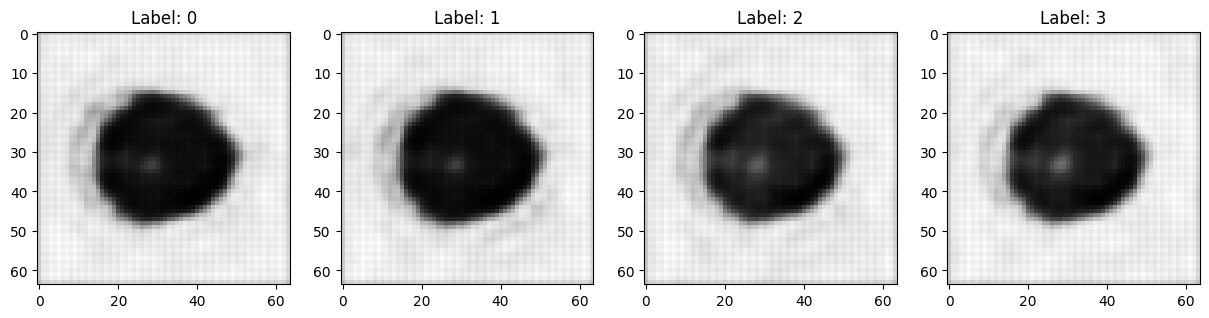

In [ ]:
z_sample = np.random.randn(1, latentDim)
print(z_sample.shape)
# Generate a sample label (assuming it's of shape (1, num_labels))
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(num_labels):
    label_sample = tf.one_hot([i], num_labels)
    combined_input = [z_sample, label_sample]

    synth = cvae.decoder.predict(combined_input)
    new_tumor = synth.reshape((64, 64, 32))
    axes[i].imshow(new_tumor[:, :, 12], cmap='gray')
    axes[i].set_title(f'Label: {i}')

plt.show()

1/1 [==============================] - 0s 20ms/step


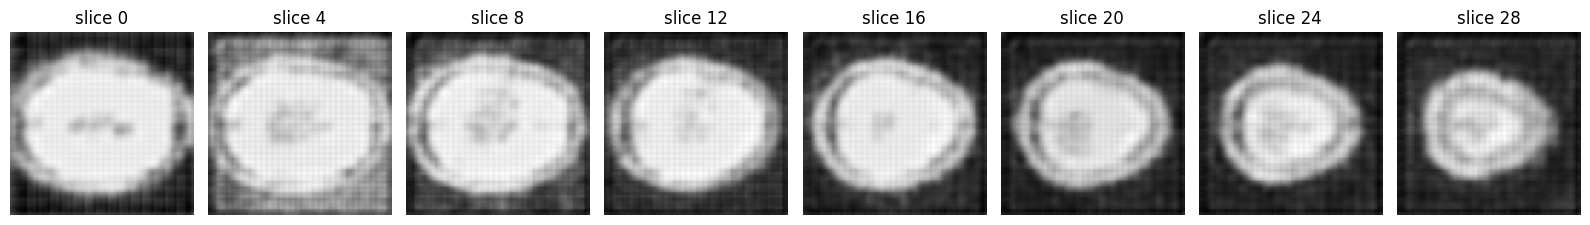

In [ ]:
z = np.random.randn(1, latentDim)
# rand_label = np.random.randint(0, num_labels, (1,))
label = tf.one_hot([3], num_labels)
combined_input = [z, label]
synth = cvae.decoder.predict(combined_input)
new_fmri = synth.reshape((64, 64, 32))

fig, axes = plt.subplots(1, 8, figsize=(16, 4))
chunk_size = new_fmri.shape[2]//8
for i in range(8):

    index = i * chunk_size
    sub_data = new_fmri[:, :, index]

    axes[i].imshow(sub_data , cmap='gray')
    axes[i].set_title(f'slice {index}')
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig('my_figure1.png')
plt.show()


In [ ]:
_, test_fmri = test_data
test_fmri[0][:,:,:,0].shape
nor_test_fmri = minmax_normalize_matrix(test_fmri)

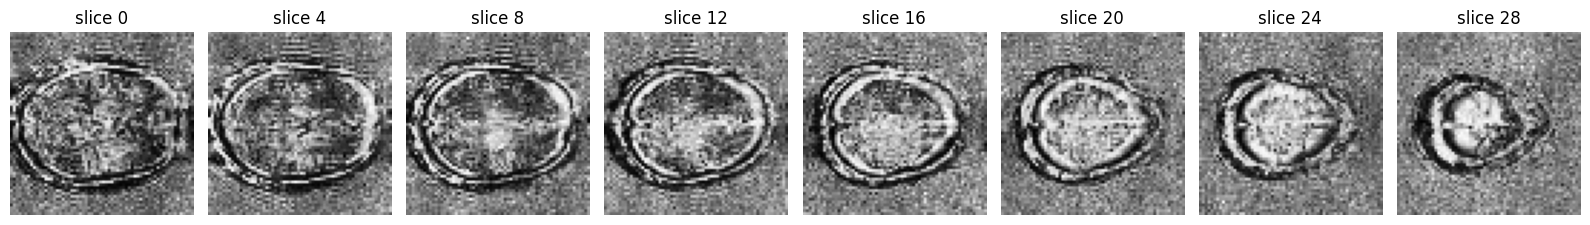

In [ ]:
# z = np.random.randn(1, latentDim)
# # rand_label = np.random.randint(0, num_labels, (1,))
# label = tf.one_hot([1], num_labels)
# combined_input = [z, label]
# synth = cvae.decoder.predict(combined_input)
new_fmritest = nor_test_fmri[200][:,:,:,0]

fig, axes = plt.subplots(1, 8, figsize=(16, 4))
chunk_size = new_fmritest.shape[2]//8
for i in range(8):

    index = i * chunk_size
    sub_data = new_fmritest[:, :, index]

    axes[i].imshow(sub_data , cmap='gray')
    axes[i].set_title(f'slice {index}')
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig('my_figure1.png')
plt.show()
